# Project Check-In 6

**Neural Network**
For Maya:
- We used MSE as Loss and stochastic Gradient descent for optimizer
- Changing the epoch count from 100 to 500 drastically improved our results
    - However! I also tried changing the learning rate to 0.001 from 0.01 and when using 100 epochs the final loss was even lower than with our old 500 epoch system. Run the code and play around with "epoch" and "lr" to see for yourself


In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

complete_data = pd.read_csv("StudentPerformanceFactors.csv")
print(np.__version__)

1.24.3


In [70]:
# Clean the data by removing rows with empty values
columns_to_drop = ["Extracurricular_Activities", "Peer_Influence", "Physical_Activity", "Gender"]
data = complete_data.drop(columns=columns_to_drop)
data = data.dropna()
data.isna().sum()
# Convert categorical columns to numerical to support clustering using euclidean (as shown in k-means)
# Convert low medium and high to 0, 1, 2
data['Parental_Involvement'] = data['Parental_Involvement'].map({'Low': 1, 'Medium': 2, 'High': 3})
data['Access_to_Resources'] = data['Access_to_Resources'].map({'Low': 1, 'Medium': 2, 'High': 3})
data['Motivation_Level'] = data['Motivation_Level'].map({'Low': 1, 'Medium': 2, 'High': 3})
data['Family_Income'] = data['Family_Income'].map({'Low': 1, 'Medium': 2, 'High': 3})
data['Teacher_Quality'] = data['Teacher_Quality'].map({'Low': 1, 'Medium': 2, 'High': 3})
# Convert "Yes" to 1 and "No" to 0
data['Learning_Disabilities'] = data['Learning_Disabilities'].map({'Yes': 1, 'No': 0})
data['Internet_Access'] = data['Internet_Access'].map({'Yes': 1, 'No': 0})
# Convert Parental Education
data['Parental_Education_Level'] = data['Parental_Education_Level'].map({
    'High School': 1,
    'College': 2,
    'Postgraduate': 3
})
# Convert School Type
data['School_Type'] = data['School_Type'].map({'Private': 1, 'Public': 0})
# Convert Distance From Home
data['Distance_from_Home'] = data['Distance_from_Home'].map({
    'Near': 1,
    'Moderate': 2,
    'Far': 3
})
data.sample(10)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Exam_Score
2274,13,84,2,2,8,98,1,0,2,2,2,0,0,2,2,66
1287,23,63,2,2,8,69,3,1,2,2,1,0,1,1,1,63
341,21,90,1,2,8,62,1,1,2,2,3,0,1,1,1,67
2600,9,86,3,2,8,86,2,1,1,1,3,0,0,1,1,65
5588,27,60,2,3,8,68,3,1,1,2,2,1,1,1,3,63
1015,21,76,2,1,5,78,3,0,0,1,3,0,0,1,1,65
2152,20,90,1,2,6,85,3,0,3,1,3,1,0,2,1,69
5205,25,76,2,2,9,53,2,1,0,3,3,1,0,1,2,67
4504,19,75,2,2,7,88,1,1,1,2,2,1,0,3,2,67
5263,23,82,1,2,8,54,2,1,0,2,3,0,0,1,1,65


In [71]:
## setup features and labels
X = data.drop("Exam_Score", axis=1).values
y = data["Exam_Score"].values

In [72]:
## split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
## scale the features, since not all on the same scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [74]:
## Convert to Tensors so we can use the tensor module' NN functionalities
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
## creating the Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 1
# Initialize the model, loss function, and optimizer
model = SimpleNN(input_dim, hidden_dim, output_dim)
loss_fn = nn.MSELoss()
## the lr here is learning rate, 0.001 seems to do better than the standard 0.01
optimizer = optim.SGD(model.parameters(), lr=0.001)


In [76]:
# Training loop
print("\n### Training the Neural Network ###")
epochs = 100
for epoch in range(epochs):
    # Forward pass
    predictions = model(X_train_t).squeeze()
    loss = loss_fn(predictions, y_train_t)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: ")

## For maya: add validation loss tracking^(put it above, i already wrote the label)

# Detailed Neural Network Explanation
print("\n### Detailed Neural Network Explanation ###")


### Training the Neural Network ###
Epoch [10/100], Loss: 3604.1270, Validation Loss: 
Epoch [20/100], Loss: 1300.4392, Validation Loss: 
Epoch [30/100], Loss: 55.6607, Validation Loss: 
Epoch [40/100], Loss: 10.9008, Validation Loss: 
Epoch [50/100], Loss: 9.7706, Validation Loss: 
Epoch [60/100], Loss: 9.5168, Validation Loss: 
Epoch [70/100], Loss: 9.3385, Validation Loss: 
Epoch [80/100], Loss: 9.1762, Validation Loss: 
Epoch [90/100], Loss: 9.0227, Validation Loss: 
Epoch [100/100], Loss: 8.8776, Validation Loss: 

### Detailed Neural Network Explanation ###


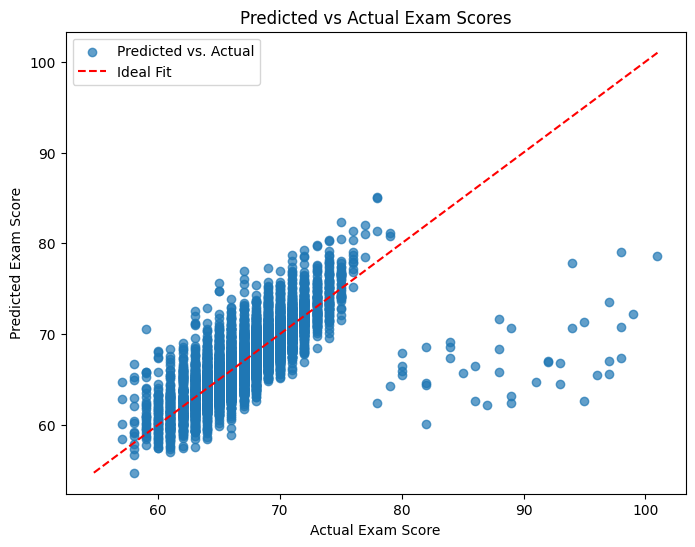

In [77]:
# Switch model to evaluation mode
model.eval()

# Get predictions
with torch.no_grad():
    predictions = model(X_train_t).squeeze()  # Ensure shape matches y_train
    
# Convert to numpy for plotting
predictions_np = predictions.detach().numpy()
actuals_np = y_train_t.numpy()

plt.figure(figsize=(8, 6))
plt.scatter(actuals_np, predictions_np, label="Predicted vs. Actual", alpha=0.7)

# Plot a diagonal line for reference (ideal predictions)
min_val = min(actuals_np.min(), predictions_np.min())
max_val = max(actuals_np.max(), predictions_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')

plt.title("Predicted vs Actual Exam Scores")
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.legend()
plt.show()